In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
#load the dataset
data = pd.read_csv("preprocessed_data.csv")
print("Dataset loaded successfully.")
print(data.head())

Dataset loaded successfully.
   latitude  housing_median_age  total_rooms  total_bedrooms  households  \
0  0.564293                 1.0     0.258241        0.160547    0.160846   
1  0.564293                 1.0     0.224220        0.198975    0.199449   
2  0.564293                 1.0     0.286445        0.237404    0.236213   
3  0.564293                 1.0     0.161643        0.180188    0.175551   
4  0.563231                 1.0     0.446501        0.415884    0.470588   

   median_income  median_house_value  ocean_proximity_<1H OCEAN  \
0       0.899633            352100.0                        0.0   
1       0.684719            341300.0                        0.0   
2       0.445496            342200.0                        0.0   
3       0.470871            269700.0                        0.0   
4       0.420587            299200.0                        0.0   

   ocean_proximity_INLAND  ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
0                     0.0       

In [3]:
#seperate features and target
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

In [4]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 13947, Testing samples: 3487


In [5]:
#random forest regression implementation
rf = RandomForestRegressor(random_state=42)

In [6]:
#hyperparameter tuning using GridSearch
param_grid = {
    'n_estimators': [100, 200, 300],           # number of trees
    'max_depth': [None, 10, 20, 30],          # max depth of tree
    'min_samples_split': [2, 5, 10],          # minimum samples to split
    'min_samples_leaf': [1, 2, 4]             # minimum samples at leaf node
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2'  # R-squared metric for regression
)

In [7]:
#fit GridSearch to training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2')

In [8]:
#best parameters after tuning
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}


In [9]:
#train final Random Forest model with best hyperparameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
print("Random Forest model trained successfully.")

Random Forest model trained successfully.


In [10]:
# Create an empty dictionary
user_input = {}

# Ask user for numeric feature values
user_input['latitude'] = float(input("Enter latitude: "))
user_input['housing_median_age'] = float(input("Enter housing_median_age: "))
user_input['total_rooms'] = float(input("Enter total_rooms: "))
user_input['total_bedrooms'] = float(input("Enter total_bedrooms: "))
user_input['households'] = float(input("Enter households: "))
user_input['median_income'] = float(input("Enter median_income: "))

# One-hot encoded ocean proximity categories
categories = [
    'ocean_proximity_<1H OCEAN',
    'ocean_proximity_INLAND',
    'ocean_proximity_ISLAND',
    'ocean_proximity_NEAR BAY',
    'ocean_proximity_NEAR OCEAN'
]

print("\nSelect Ocean Proximity:")
for i, cat in enumerate(categories, 1):
    print(f"{i}. {cat.replace('ocean_proximity_', '')}")

choice = int(input("Enter the number (1-5): "))

# Validate and assign one-hot values
for idx, cat in enumerate(categories, 1):
    user_input[cat] = 1 if idx == choice else 0

# Convert to DataFrame
input_df = pd.DataFrame([user_input])

# Predict
predicted_value = best_rf.predict(input_df)
print(f"\n✅ Predicted median_house_value: ${predicted_value[0]:,.2f}")


Enter latitude:  34.2
Enter housing_median_age:  20
Enter total_rooms:  3000
Enter total_bedrooms:  500
Enter households:  450
Enter median_income:  4.5



Select Ocean Proximity:
1. <1H OCEAN
2. INLAND
3. ISLAND
4. NEAR BAY
5. NEAR OCEAN


Enter the number (1-5):  4



✅ Predicted median_house_value: $410,513.83


In [11]:
#progress review III
#evaluation metrics for regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

#predict on test set
y_pred_rf = best_rf.predict(X_test)

#calculate metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regression Metrics:")
print(f"MSE: {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R²: {r2_rf:.2f}")

Random Forest Regression Metrics:
MSE: 2779661084.88
RMSE: 52722.49
MAE: 37765.45
R²: 0.68


In [12]:
#k-fold cross validation
from sklearn.model_selection import cross_val_score

# 10-fold cross-validation on the full dataset
cv_scores_rf = cross_val_score(best_rf, X, y, cv=10, scoring='r2', n_jobs=-1)
print(f"Random Forest 10-Fold CV R² scores: {cv_scores_rf}")
print(f"Average CV R²: {cv_scores_rf.mean():.2f}")


Random Forest 10-Fold CV R² scores: [-0.32298273  0.6062136   0.4612933  -0.1867291   0.4816079   0.4554603
  0.2257806   0.34871744  0.31022193  0.60411769]
Average CV R²: 0.30


In [13]:
#model comparison
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor

#initializing other models used
models = {
    'Random Forest': best_rf,
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(max_iter=10000, alpha=0.1), 
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42)
}

#evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

#convert to DataFrame for comparison
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)


C:\Users\rasin\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.369e+12, tolerance: 1.228e+10
  model = cd_fast.enet_coordinate_descent(


                         R2          RMSE           MAE
Random Forest      0.680888  52722.491262  37765.454090
Extra Trees        0.652532  55015.049233  39771.496387
Gradient Boosting  0.650387  55184.588129  40567.460537
Lasso Regression   0.574771  60860.467071  45771.939101
Linear Regression  0.574766  60860.839925  45772.024379
Decision Tree      0.333053  76220.114519  52370.318612


In [14]:
# SAVE TRAINED MODEL TO .joblib
from joblib import dump

# Save your tuned Random Forest model (the final trained one)
dump(best_rf, 'uththara_random_forest.joblib')

print("✅ Model saved successfully as uththara_random_forest.joblib")


✅ Model saved successfully as uththara_random_forest.joblib



===== MODEL COMPARISON (GROUP MEMBERS) =====


Matplotlib is building the font cache; this may take a moment.



Model Performance Comparison:
                                    R² Score       RMSE        MAE
Gradient Boosting (Buddhima)           0.697  51385.914  36597.980
Random Forest Regressor (Uththara)     0.681  52722.491  37765.454
Extra Trees Regressor (Imesh)          0.665  54049.108  39191.376
Linear Regression (Samadhi)            0.575  60860.840  45772.024
Decision Tree (Nidurshan)              0.333  76220.115  52370.319
Lasso Regression (Wathmavi)            0.168  85113.274  72348.275


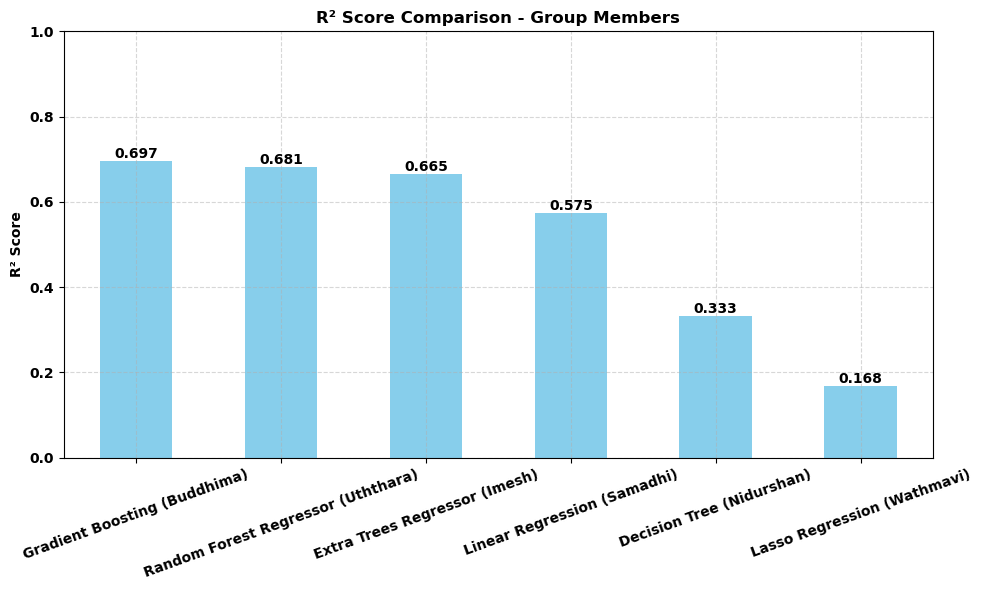

<Figure size 1000x600 with 0 Axes>

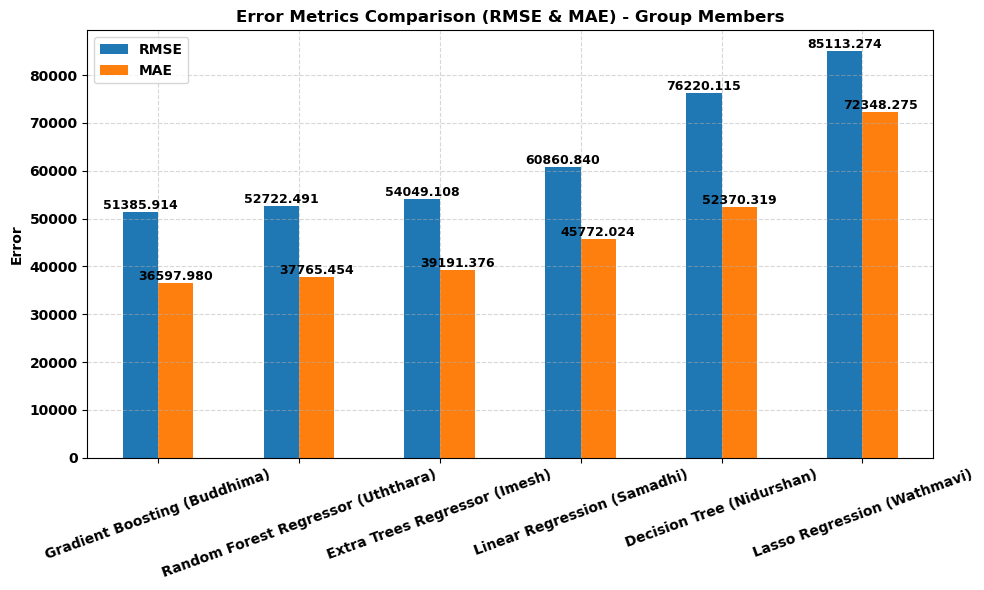


✅ Best performing model: Gradient Boosting (Buddhima) with R² = 0.697


In [15]:
#model comparison with team members actual trained models

print("\n===== MODEL COMPARISON (GROUP MEMBERS) =====")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#load all models
uththara_model = best_rf  #random forest my model

samadhi_model = load('samadhi_linear_model.joblib')
wathmavi_model = load('wathmavi_lasso_model.joblib')
nidurshan_model = load('nidurshanfile.joblib')
buddhima_model = load('buddhima_gradient_boosting.joblib')
imesh_model = load('Extra_Trees_Model.joblib')


models = {
    'Random Forest Regressor (Uththara)': uththara_model,
    'Linear Regression (Samadhi)': samadhi_model,
    'Lasso Regression (Wathmavi)': wathmavi_model,
    'Decision Tree (Nidurshan)': nidurshan_model,
    'Gradient Boosting (Buddhima)': buddhima_model,
    'Extra Trees Regressor (Imesh)': imesh_model
}


#evaulating each model on the same test data
results = {}

for name, model in models.items():
    try:
        # If model was fitted without feature names, convert X_test to NumPy array
        X_input = X_test.values if 'Lasso' in name else X_test
        y_pred = model.predict(X_input)
        results[name] = {
            'R² Score': r2_score(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred)
        }
    except Exception as e:
        print(f"⚠️ Error evaluating {name}: {e}")



#convert to dataframe for cleaner display
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='R² Score', ascending=False)

print("\nModel Performance Comparison:")
print(results_df.round(3).to_string())


#visualize model performance comparison
#R^2 scores
plt.figure(figsize=(10,6))
ax1 = results_df['R² Score'].plot(kind='bar', color='skyblue')
plt.title("R² Score Comparison - Group Members")
plt.ylabel("R² Score")
plt.xticks(rotation=20)
plt.ylim(0, 1)  # R² usually between 0 and 1
plt.grid(True, linestyle='--', alpha=0.5)

# Annotate bars with values
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.3f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

#RMSE AND MSE
plt.figure(figsize=(10,6))
ax2 = results_df[['RMSE', 'MAE']].plot(kind='bar', figsize=(10,6))
plt.title("Error Metrics Comparison (RMSE & MAE) - Group Members")
plt.ylabel("Error")
plt.xticks(rotation=20)
plt.grid(True, linestyle='--', alpha=0.5)

# Annotate bars with values
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.3f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

#interpretation

best_model_name = results_df.index[0]
best_r2 = results_df.iloc[0]['R² Score']
print(f"\n✅ Best performing model: {best_model_name} with R² = {best_r2:.3f}")
